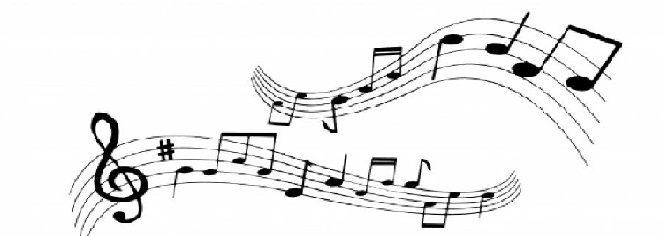

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:200%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Обнаружение каверов музыкальных треков</p>

</div>


<div style="padding:20px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
        
__Постановка задачи:__ Определение оригинальных треков среди каверов будет использоваться для улучшения рекомендаций музыкального сервиса и увеличения вовлеченности создателей трансляций.
    
__Оценка результата:__ Для оценки качества будет использоваться мертика ROC-AUC.
    
__Описание данных:__ Выгрузки из баз данных музыкального сервиса:  
<ul> <b>Covers</b>
<li>track_id - уникальный идентификатор трека;</li>
<li>track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;</li>
<li>original_track_id - уникальный идентификатор исходного трека.</li>
</ul>
<ul> <b>Lyrics</b>
<li>track_id - уникальный идентификатор трека;</li>
<li>lyricId - уникальный идентификатор текста;</li>
<li>text - текст трека.</li>
</ul>
<ul> <b>Meta</b>
<li>track_id - уникальный идентификатор трека;</li>
<li>dttm - первая дата появления информации о треке;</li>
<li>title - название трека;</li>
<li>language - язык исполнения;
<li>isrc - международный уникальный идентификатор трека;</li>
<li>genres - жанры;</li>
<li>duration - длительность трека;</li>
</ul>
</div>    

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
<ul> <b>План</b>
<li>Изучим и предобработаем данные.</li> 
<li>Разделим исходные данные на обучающую и тестовую выборки.</li> 
<li>Проведем масштабирование и кодировку признаков.</li> 
<li>Исследуем качество модели, меняя гиперпараметры. Кратко опишем выводы исследования.</li> 
</ul>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка библиотек

</div>

In [39]:
import re
import torch
import transformers
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from tqdm import notebook
from sklearn import metrics

from matplotlib import pyplot as plt
from transformers import BertModel, BertForMaskedLM
from transformers import BertTokenizer
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 

In [2]:
torch.cuda.is_available()

True

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных, EDA

</div>

In [3]:
meta = pd.read_json('D:/programs/projects/yandex_music/meta.json', lines= True, convert_dates=['dttm'])
meta.info()
display(meta.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  71768 non-null  object        
 1   dttm      71768 non-null  datetime64[ns]
 2   title     71768 non-null  object        
 3   language  21969 non-null  object        
 4   isrc      71455 non-null  object        
 5   genres    71768 non-null  object        
 6   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
36188,0eb80297c0159b64b1e8cd4ba5b905b9,2021-10-07 04:28:01,Permission to Dance,None,AUXN22200869,[POP],211000.0
11087,c1c9c30a19dbb412c3f1e362f0efe655,2022-05-30 17:49:33,"Tu Tá Querendo, Tá",None,QZMZ92206578,"[FOLK, LATINFOLK]",145880.0
34169,36583a6764bebe75ece1a3a80baad30e,2021-09-16 19:52:01,Popurrit Don Jose/bailable,None,QZDFP1939563,"[FOLK, LATINFOLK]",520590.0
1712,cbf112d1141c33bc814a29be96aedc34,2021-12-16 01:48:24,Ilha,None,QZTPX2193950,[],231950.0
5122,7865aba5a95f96b25d242fc397bf2c4c,2022-02-07 22:41:17,Baby Yo Te Quiero,None,QZGLM2213294,"[REGGAE, REGGAETON]",180370.0


In [4]:
#load covers
covers = pd.read_json('D:/programs/projects/yandex_music/covers.json', lines= True)
covers.info()
display(covers.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


,original_track_id,track_id,track_remake_type
54766,None,4d63b92354349d972a964e13e4dec4f0,COVER
59946,None,c293203879bcb51b24a26dcd4f681363,COVER
36036,None,31aad7b9d14e9d8863aea0b90e79666b,COVER
52299,None,8e985577edab7793f910cf9bdccc8f60,COVER
22703,None,1e4d81426613e357905ade87b40614fb,COVER


In [5]:
#load lyrics
lyrics = pd.read_json('D:/programs/projects/yandex_music/lyrics.json', lines= True)
lyrics.info()
display(lyrics.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
3726,cc11f95eedfb7be608914a2b67c8e3f8,Friday night you and your boys went out to eat...,9e755811384159ee44a9b34d15772037
7585,12d8f82e22bc3876199f333e495a705e,"По лицу роса, я к тебе босая\nИ слова бросаю п...",10280f11625d86adb5b25cc8cc3677fd
6803,20fc49dfb8837423fe3f1abad59424a4,Olhei até ficar cansado\nDe ver os meus olhos ...,165e39cb94d51fe226280050b4d09030
1778,30d9e75fd47a951626047105e0e08ed4,I see your face in my mind as I drive away\n'C...,90117fc7a8a5ef80c4d3e1e6e39b4f06
11354,0d170307775e04d5875c6040e0b067dd,"Моя вера, помоги не продаться за рубли\nНам бе...",e669b98a79b2012f07c52b3b5e448774


<div style="border-radius:10px; 
            border:#DEB887 solid; 
            padding: 15px; 
            background-color: #FFFAF0; 
            font-size:120%; 
            text-align:left">
    Объединим данные.

In [6]:
df = pd.merge(meta, covers, how = 'outer', on="track_id")
df = pd.merge(df, lyrics, how = 'outer', on="track_id")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72906 entries, 0 to 72905
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           72905 non-null  object        
 1   dttm               72905 non-null  datetime64[ns]
 2   title              72905 non-null  object        
 3   language           22870 non-null  object        
 4   isrc               72566 non-null  object        
 5   genres             72905 non-null  object        
 6   duration           72905 non-null  float64       
 7   original_track_id  5378 non-null   object        
 8   track_remake_type  72571 non-null  object        
 9   lyricId            11414 non-null  object        
 10  text               11414 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 6.1+ MB


,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
38423,33a37f86d25162a95de718a02c857950,2021-10-28 17:51:49,Estranho,None,QZNJY2111215,"[FOLK, LATINFOLK]",176320.0,None,COVER,NaN,NaN
63699,7fc5d97afff9c5ce4ccc376f50c4e877,2021-02-25 10:16:20,Fui Eu,None,US7VG2199259,"[FOLK, LATINFOLK]",284780.0,None,COVER,NaN,NaN
61690,d6274e4b903725c0398c4903444c4710,2021-01-21 22:32:02,Gunz of Brixton,None,QZ5AB2166467,[REGGAE],238160.0,None,COVER,NaN,NaN
55078,54becf61a0e5e5db2234d11639417a2d,2020-07-09 22:06:06,Outlaw Shit,None,QZHZ52071984,"[FOREIGNBARD, BARD]",257500.0,None,COVER,NaN,NaN
19133,55736563b03b5a91a0e47bac1931516d,2020-04-24 21:00:00,Addicted to You,EN,QM6MZ2043239,[ELECTRONICS],214660.0,None,COVER,NaN,NaN


In [7]:
df.describe(include='all')

,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
count,72905,72905,72905,22870,72566,72905,7.290500e+04,5378,72571,11414,11414
unique,71768,NaN,45462,85,71283,232,NaN,4468,2,10915,10644
top,b891000882f4a612190142861b5c038b,NaN,Morena,EN,US4BR0500030,"[FOLK, LATINFOLK]",NaN,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,6fe05ce48761f833737487cd7a499cd3,Twenty-five years and my life is still\nI'm tr...
freq,24,NaN,81,16121,24,18399,NaN,41,67770,9,15
mean,NaN,2020-02-22 02:06:38.293176064,NaN,NaN,NaN,NaN,2.051841e+05,NaN,NaN,NaN,NaN
min,NaN,2009-08-10 17:32:06,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,2019-07-28 21:15:47,NaN,NaN,NaN,NaN,1.616300e+05,NaN,NaN,NaN,NaN
50%,NaN,2021-05-03 21:37:10,NaN,NaN,NaN,NaN,1.996500e+05,NaN,NaN,NaN,NaN
75%,NaN,2021-11-12 22:24:01,NaN,NaN,NaN,NaN,2.392800e+05,NaN,NaN,NaN,NaN
max,NaN,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,5.487300e+06,NaN,NaN,NaN,NaN


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:120%; text-align:left">В данных обнаружены пропуски и дубликаты, некоторые данные стоит перевести в другой формат.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка данных

</div>

In [10]:
df['isrc'] = df['isrc'].str.replace("-","")
df.dropna(subset=['isrc', 'track_remake_type', 'duration'], inplace=True)

In [11]:
df['duration'] = df['duration'].astype('int')

In [12]:
df.track_remake_type.value_counts()

track_remake_type
COVER       67546
ORIGINAL     4696
Name: count, dtype: int64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:120%; text-align:left">Создадим новый признак - год появения трека в базе isrc. Напишем функцию, которая будет возвращать нам год из 6-го и 7-го символов isrc-кода.

In [13]:
def convert(x):
    try:
        return '19' + x[5:7] if int(x[5:7]) > 23 else '20' + x[5:7]
    except ValueError:
        return None

In [23]:
df['isrc_year'] = df['isrc'].apply(convert).astype('int')

In [24]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 72242 entries, 0 to 72905
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           72242 non-null  object        
 1   dttm               72242 non-null  datetime64[ns]
 2   title              72242 non-null  object        
 3   language           22593 non-null  object        
 4   isrc               72242 non-null  object        
 5   genres             72242 non-null  object        
 6   duration           72242 non-null  int32         
 7   original_track_id  5270 non-null   object        
 8   track_remake_type  72242 non-null  object        
 9   lyricId            11018 non-null  object        
 10  text               11018 non-null  object        
 11  year               72242 non-null  int32         
 12  isrc_year          72242 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(9)
memory usage: 6.9+ MB


,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text,year,isrc_year
count,72242,72242,72242,22593,72242,72242,7.224200e+04,5270,72242,11018,11018,72242.000000,72242.000000
unique,71287,NaN,45228,85,71115,229,NaN,4379,2,10545,10321,NaN,NaN
top,adc126c946551da4e1784e716b77992e,NaN,Morena,EN,USAT21202802,"[FOLK, LATINFOLK]",NaN,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,28fbafaf626c497d0d4d933b4f0d3f5b,Twenty-five years and my life is still\nI'm tr...,NaN,NaN
freq,17,NaN,81,15866,17,18399,NaN,40,67546,9,15,NaN,NaN
mean,NaN,2020-03-03 07:14:45.602918144,NaN,NaN,NaN,NaN,2.050357e+05,NaN,NaN,NaN,NaN,2018.444091,2018.444091
min,NaN,2009-08-10 17:32:06,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,1924.000000,1924.000000
25%,NaN,2019-09-06 16:58:42.249999872,NaN,NaN,NaN,NaN,1.614300e+05,NaN,NaN,NaN,NaN,2018.000000,2018.000000
50%,NaN,2021-05-06 06:03:14,NaN,NaN,NaN,NaN,1.994600e+05,NaN,NaN,NaN,NaN,2021.000000,2021.000000
75%,NaN,2021-11-14 23:58:05.750000128,NaN,NaN,NaN,NaN,2.391500e+05,NaN,NaN,NaN,NaN,2021.000000,2021.000000
max,NaN,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,5.487300e+06,NaN,NaN,NaN,NaN,2023.000000,2023.000000


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:120%; text-align:left"> Подготовим 'title' для дальнейшей обработки

In [25]:
#Cоздаем копию DataFrame, чтобы избежать изменения исходных данных
data = df.copy()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 72242 entries, 0 to 72905
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           72242 non-null  object        
 1   dttm               72242 non-null  datetime64[ns]
 2   title              72242 non-null  object        
 3   language           22593 non-null  object        
 4   isrc               72242 non-null  object        
 5   genres             72242 non-null  object        
 6   duration           72242 non-null  int32         
 7   original_track_id  5270 non-null   object        
 8   track_remake_type  72242 non-null  object        
 9   lyricId            11018 non-null  object        
 10  text               11018 non-null  object        
 11  year               72242 non-null  int32         
 12  isrc_year          72242 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(9)
memory usage: 6.9+ MB
No

In [26]:
# Приводим все названия треков к нижнему регистру
data['title'] = data['title'].str.lower()

# Удаляем все знаки препинания и символы
data['title'] = data['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [27]:
data.loc[data['track_remake_type'] == 'ORIGINAL','original'] = 1
data.loc[data['track_remake_type'] == 'COVER','original'] = 0
data['original'] = data['original'].astype('int')

In [28]:
data.original.value_counts()

original
0    67546
1     4696
Name: count, dtype: int64

In [29]:
data.to_csv('D:/programs/projects/yandex_music/data_final.csv')

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 font-size: 120%;
                                                 width:80%;
                                                 margin: auto;
                                                 text-align: left;">
<b>Промежуточные итоги: </b>
<ul>
<li>Объединили данные, вынесли в отдельный датасет
<li>Удалены пропуски в столбце 'isrc'
<li>Создан признак isrc_year - год добавления в базу данных isrc
<li>Столбец 'title' очищен от знаков препинаний и символов
<li>Создан целевой признак original   
<ul>
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных для обучения

</div>

In [30]:
rand = 12345
train, valid = train_test_split(
    data, 
    test_size=0.4, 
    stratify = data['original'], 
    random_state = rand
)

valid, test = train_test_split(
    valid, 
    test_size=0.50, 
    stratify = valid['original'], 
    random_state = rand
)

In [31]:
x_train = train[['title','isrc_year', 'duration']]
y_train = train['original']
x_valid = valid[['title','isrc_year', 'duration']]
y_valid = valid['original']
x_test = test[['title','isrc_year', 'duration']]
y_test = test['original']
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(43345, 3)
(43345,)
(14448, 3)
(14448,)
(14449, 3)
(14449,)


In [32]:
y_test.sum()

939

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:90%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
    
## Подготовка числовых признаков

</div>

In [33]:
#Векторизация численных признаков
numeric = ['isrc_year', 'duration']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train_num = scaler.transform(x_train[numeric])
x_valid_num = scaler.transform(x_valid[numeric])
x_test_num = scaler.transform(x_test[numeric])
print(x_train_num)

[[ 0.45113156 -0.92661379]
 [ 0.80297627 -0.63920679]
 [ 0.45113156 -0.04112706]
 ...
 [ 0.45113156  2.33533412]
 [ 0.62705392 -0.26683936]
 [ 0.62705392 -0.25028713]]


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:90%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
    
## Векторизация текстовых признаков

</div>

In [34]:
def x_text_vectorization(text_column, split):
    
    # Токенизация
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained("bert-base-multilingual-cased")
    tokenized = text_column.apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)

    # Создание эмбеддингов
    batch_size = 1
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())\

    x_text_featured = np.concatenate(embeddings)
    display(x_text_featured)

    # save numpy array
    savetxt('D:/programs/projects/yandex_music/x_{}_text.csv'.format(split),x_text_featured, delimiter=',')
    np.save('D:/programs/projects/yandex_music/x_{}_text.npy'.format(split), x_text_featured)
    return x_text_featured

In [40]:
x_train_text = x_text_vectorization(x_train['title'], 'train')
x_valid_text = x_text_vectorization(x_valid['title'], 'valid')
x_test_text = x_text_vectorization(x_test['title'], 'test')

  0%|          | 0/43345 [00:00<?, ?it/s]

array([[ 0.03326398,  0.4669711 ,  0.06076509, ...,  0.27261722,
         0.3550374 ,  0.12229419],
       [ 0.07245113, -0.1376398 ,  0.4235518 , ...,  0.4930752 ,
        -0.10196283, -0.31615287],
       [ 0.02245774,  0.0804517 ,  0.24228188, ...,  0.39060622,
        -0.09134446,  0.05513977],
       ...,
       [ 0.07270588, -0.30633888,  0.3680589 , ...,  0.3387025 ,
         0.09708963,  0.06755208],
       [ 0.13976657,  0.22930665, -0.23833871, ...,  0.40484744,
         0.5002717 ,  0.12495194],
       [ 0.11622648, -0.03056975,  0.39810297, ...,  0.28734756,
         0.05815709,  0.04003861]], dtype=float32)

  0%|          | 0/14448 [00:00<?, ?it/s]

array([[ 0.22902139, -0.02270815,  0.0653175 , ...,  0.46017796,
        -0.2531219 , -0.01789307],
       [ 0.20321815, -0.2711404 ,  0.50596535, ...,  0.2161334 ,
        -0.1238417 ,  0.11375678],
       [ 0.32471663, -0.2748344 ,  0.10501359, ...,  0.24620087,
        -0.00402512,  0.1631431 ],
       ...,
       [ 0.03747323,  0.14403062, -0.05804172, ...,  0.25975543,
         0.00811798,  0.06817678],
       [ 0.3108466 , -0.21670839,  0.16199514, ...,  0.36682296,
         0.01614969, -0.03393539],
       [ 0.11668701, -0.15589122,  0.5063595 , ...,  0.37492138,
         0.01973006,  0.3031329 ]], dtype=float32)

  0%|          | 0/14449 [00:00<?, ?it/s]

array([[-0.12207018, -0.04355999, -0.02229658, ...,  0.3004169 ,
        -0.09121291, -0.17415752],
       [-0.07305947, -0.00894074,  0.23588459, ...,  0.23839332,
        -0.12873487,  0.09651961],
       [ 0.3592475 , -0.42916483,  0.3339385 , ...,  0.43316507,
        -0.23822416, -0.17308915],
       ...,
       [ 0.34537825,  0.25640047, -0.13265955, ...,  0.3221684 ,
        -0.09202845,  0.20988268],
       [-0.2923334 , -0.21345857,  0.35473073, ...,  0.1449917 ,
        -0.16895136, -0.04981856],
       [ 0.09822822, -0.17774972,  0.29834694, ...,  0.058835  ,
         0.04049797,  0.02902944]], dtype=float32)

In [41]:
x_train_text = np.load('D:/programs/projects/yandex_music/x_train_text.npy')
x_valid_text = np.load('D:/programs/projects/yandex_music/x_valid_text.npy')
x_test_text = np.load('D:/programs/projects/yandex_music/x_test_text.npy')

In [42]:
x_train_full = np.concatenate((x_train_num, x_train_text), axis=1)
print(len(x_train_full))
print(len(x_train_full[1]))

43345
770


In [43]:
x_valid_full = np.concatenate((x_valid_num, x_valid_text), axis=1)
print(len(x_valid_full))
print(len(x_valid_full[1]))

14448
770


In [45]:
x_test_full = np.concatenate((x_test_num, x_test_text), axis=1)
print(len(x_test_full))
print(len(x_test_full[1]))

14449
770


<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 font-size: 120%;
                                                 width:80%;
                                                 margin: auto;
                                                 text-align: left;">
<b>Промежуточные итоги: </b>
<ul>
<li> Разделили данные на тренировочную, валидационную и тестовую выборки
<li> создали массивы с векторами
<ul>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Обучение и выбор моделей

<div style="border-radius:10px; 
            border:#DEB887 solid; 
            padding: 15px; 
            background-color: #FFFAF0; 
            font-size:120%; 
            text-align:left"> 
    Для оценки моделей выбрана метрика ROC-AUC-SCORE, так как она ппоказывает высокую эффективность при обработке данных с сильным дизюалансом классов.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:90%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
    
## Logistic Regression

</div>

In [111]:
logreg = LogisticRegression(solver='lbfgs',
                            max_iter=10000,
                            class_weight = 'balanced'
                           )
logreg.fit(x_train_full, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [124]:
logreg_predictions = logreg.predict(x_valid_full)
print(metrics.confusion_matrix(y_valid, logreg_predictions))
print(metrics.roc_auc_score(y_valid, logreg_predictions))

[[11332  2177]
 [  209   730]]
0.808135482746445


In [174]:
log_predict_proba = cross_val_predict(logreg, x_valid_full, y_valid, method='predict_proba')
print(log_predict_proba)

[[0.97355651 0.02644349]
 [0.99555697 0.00444303]
 [0.73981598 0.26018402]
 ...
 [0.99781263 0.00218737]
 [0.9839037  0.0160963 ]
 [0.99874591 0.00125409]]


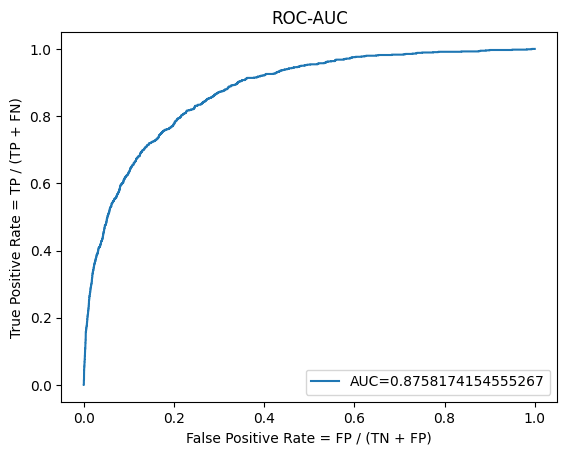

<Figure size 600x400 with 0 Axes>

In [175]:
log_predict_proba1 = log_predict_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, log_predict_proba1)
auc = metrics.roc_auc_score(y_valid, log_predict_proba1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC-AUC')
plt.ylabel('True Positive Rate = TP / (TP + FN)')
plt.xlabel('False Positive Rate = FP / (TN + FP)')
plt.legend(loc=4)
plt.figure(figsize=(6,4))
plt.show()

[[11332  2177]
 [  209   730]]
0.808135482746445


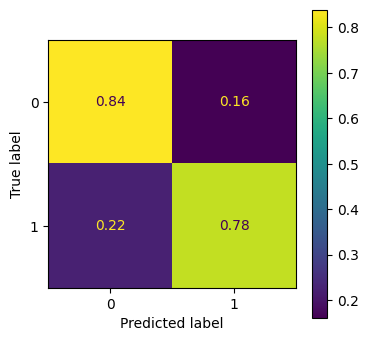

In [181]:
print(metrics.confusion_matrix(y_valid, logreg_predictions))
print(metrics.roc_auc_score(y_valid, logreg_predictions))
cm = metrics.confusion_matrix(y_valid, logreg_predictions, labels=logreg.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=logreg.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()


<div style="border-radius:10px; 
            border:#DEB887 solid; 
            padding: 15px; 
            background-color: #FFFAF0; 
            font-size:120%; 
            text-align:left"> 
Модель Logistic regression показала ROC-AUC 0.808135482746445

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
    
## LightGBM

</div>

In [128]:
lgbm = LGBMClassifier(
    class_weight = 'balanced'
    )
lgbm.fit(x_train_full, y_train)

[LightGBM] [Info] Number of positive: 2818, number of negative: 40527
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.473895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196137
[LightGBM] [Info] Number of data points in the train set: 43345, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced')

In [130]:
lgbm_predictions = lgbm.predict(x_valid_full)
print(metrics.confusion_matrix(y_valid, lgbm_predictions))
print(metrics.roc_auc_score(y_valid, lgbm_predictions))

[[12590   919]
 [  204   735]]
0.8573594411204268


In [131]:
lgbm_predict_proba = cross_val_predict(lgbm, x_valid_full, y_valid, method='predict_proba')
print(lgbm_predict_proba)

[LightGBM] [Info] Number of positive: 751, number of negative: 10807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196137
[LightGBM] [Info] Number of data points in the train set: 11558, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 751, number of negative: 10807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196138
[LightGBM] [Info] Number of data points in the train set: 11558, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM]

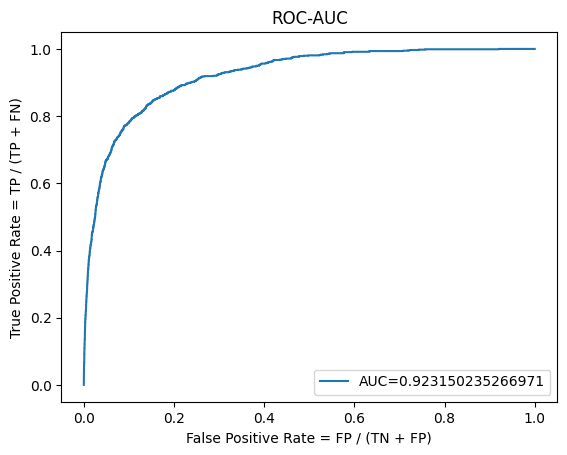

<Figure size 600x400 with 0 Axes>

In [132]:
lgbm_predict_proba1 = lgbm_predict_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, lgbm_predict_proba1)
auc = metrics.roc_auc_score(y_valid, lgbm_predict_proba1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC-AUC')
plt.ylabel('True Positive Rate = TP / (TP + FN)')
plt.xlabel('False Positive Rate = FP / (TN + FP)')
plt.legend(loc=4)
plt.figure(figsize=(6,4))
plt.show()

[[12590   919]
 [  204   735]]
0.8573594411204268


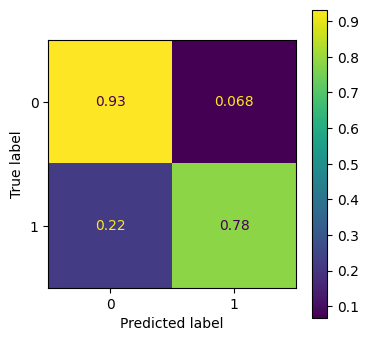

In [182]:
print(metrics.confusion_matrix(y_valid, lgbm_predictions))
print(metrics.roc_auc_score(y_valid, lgbm_predictions))
cm = metrics.confusion_matrix(y_valid, lgbm_predictions, labels=lgbm.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgbm.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()

<div style="border-radius:10px; 
            border:#DEB887 solid; 
            padding: 15px; 
            background-color: #FFFAF0; 
            font-size:120%; 
            text-align:left"> 
Модель LightGBM показала ROC-AUC 0.8573594411204268

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:90%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
    
## CatBoost

</div>

In [ ]:
catboost = CatBoostClassifier(auto_class_weights = 'Balanced')
catboost.fit(x_train_full, y_train)

In [163]:
catboost_predictions = catboost.predict(x_valid_full)
print(metrics.confusion_matrix(y_valid, catboost_predictions))
print(metrics.roc_auc_score(y_valid, catboost_predictions))

[[12903   606]
 [  251   688]]
0.8439176863986309


In [ ]:
catboost_predict_proba = cross_val_predict(catboost, x_valid_full, y_valid, method='predict_proba')
print(catboost_predict_proba)

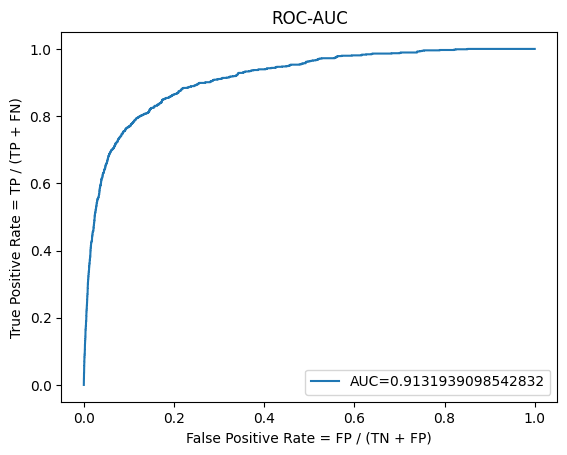

<Figure size 600x400 with 0 Axes>

In [164]:
catboost_predict_proba1 = catboost_predict_proba[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, catboost_predict_proba1)
auc = metrics.roc_auc_score(y_valid, catboost_predict_proba1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('ROC-AUC')
plt.ylabel('True Positive Rate = TP / (TP + FN)')
plt.xlabel('False Positive Rate = FP / (TN + FP)')
plt.legend(loc=4)
plt.figure(figsize=(6,4))
plt.show()

[[12903   606]
 [  251   688]]
0.8439176863986309


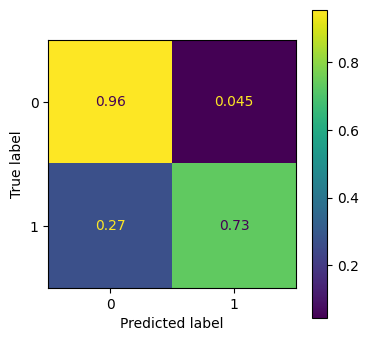

In [183]:
print(metrics.confusion_matrix(y_valid, catboost_predictions))
print(metrics.roc_auc_score(y_valid, catboost_predictions))
cm = metrics.confusion_matrix(y_valid, catboost_predictions, labels=catboost.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=catboost.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()


<div style="border-radius:10px; 
            border:#DEB887 solid; 
            padding: 15px; 
            background-color: #FFFAF0; 
            font-size:120%; 
            text-align:left"> 
    Результаты модели CatBoost оказались ниже предыдущей, ROC-AUC составила 0.8439176863986309

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 font-size: 120%;
                                                 width:80%;
                                                 margin: auto;
                                                 text-align: left;">
<b>Промежуточные итоги: </b>
<ul>
<li> Обучили три модели, Лучшей моделью оказалась LightGBM с roc-auc-score 0.8573594411204268.
<br> Ее переобучим на полных данных и проведем GridSearchCV для подбора гиперпараметров
<ul> 

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:90%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
    
## Оптимизация выбранной модели

</div>

In [184]:
x_last_train_full = np.concatenate((x_train_full, x_valid_full), axis=0)
print(len(x_last_train_full))
print(len(x_last_train_full[1]))
y_last_train_full = np.concatenate((y_train, y_valid), axis=0)
print(len(y_last_train_full))

57793
770
57793


In [185]:
%%time

parameters = {
     'num_iterations': [700],
     'learning_rate':[0.01],
    'num_leaves':[31],
    'max_depth' :[25]
}

grid_search = GridSearchCV(estimator=lgbm, param_grid=parameters, 
                           cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(x_last_train_full, y_last_train_full)

print('Best parameters:', grid_search.best_params_)
print('Best parameters:', grid_search.best_score_)

D:\programs\Anaconda3\envs\pytorch\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3757, number of negative: 54036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196136
[LightGBM] [Info] Number of data points in the train set: 57793, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best parameters: {'learning_rate': 0.01, 'max_depth': 25, 'num_iterations': 700, 'num_leaves': 31}
Best parameters: 0.9465600430379967
CPU times: total: 7min 1s
Wall time: 9min 5s


In [186]:
best_est = grid_search.best_estimator_

In [187]:
best_est

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=25,
               num_iterations=700)

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Проверка на тестовых данных

In [188]:
best_est.fit(x_last_train_full, y_last_train_full)

D:\programs\Anaconda3\envs\pytorch\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3757, number of negative: 54036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196136
[LightGBM] [Info] Number of data points in the train set: 57793, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=25,
               num_iterations=700)

In [192]:
predict_test = best_est.predict(x_test_full)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[[12334  1176]
 [  130   809]]
0.8872541067280262


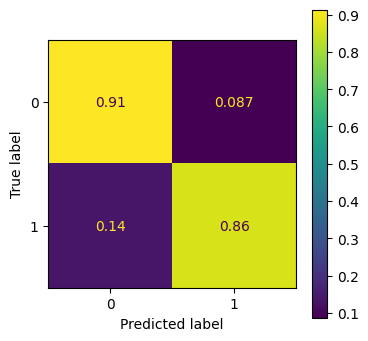

In [194]:
print(metrics.confusion_matrix(y_test, predict_test))
print(metrics.roc_auc_score(y_test, predict_test))
cm = metrics.confusion_matrix(y_test, predict_test, labels=catboost.classes_,
                      normalize = 'true'
                     )
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=catboost.classes_)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()


<div style="border-radius:10px; 
            border:#DEB887 solid; 
            padding: 15px; 
            background-color: #FFFAF0; 
            font-size:120%; 
            text-align:left"> 
<ul>
<li>Результаты на тесстовых данных лучше, чем на валидационных - это подтверждает выбор модели и исключает переобучение.
<li> ROC-AUC  = 0.8872541067280262
<li>
Теперь получим список всех треков-оригиналов из нашей тестовой выборки.

In [220]:
predictions_full = best_est.predict(x_test_full)

# получаем индексы строк, где модель предсказывает 1
indices = np.where(predict_test == 1)

# выгружаем все строки с индексами, где модель предсказала 1
predicted_data = test.iloc[indices]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [223]:
predicted_data.head(20)

,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text,year,isrc_year,original
53707,2f2f61b07108cca4c4d68d6d7880abc4,2017-06-29 21:00:00,attention,None,ITI731700183,[POP],171230,None,COVER,NaN,NaN,2017,2017,0
43374,c3714aac6bd2d12b4d5a9c243e99f0d8,2015-02-04 09:12:27,still waiting,EN,USUM70955152,[ALTERNATIVE],159250,c3714aac6bd2d12b4d5a9c243e99f0d8,ORIGINAL,ae2fa85ac5815453f76ca73166bfcfef,So am I still waiting\nFor this world to stop ...,2009,2009,1
20024,0593e5795ca6ab4ffba2e3056a7fe996,2020-05-30 21:00:00,hes pirate,EN,QM6N22048445,[SOUNDTRACK],118460,None,COVER,NaN,NaN,2020,2020,0
58675,d2b03b45d57baa6e0c737ed3cc1836a3,2020-12-23 21:00:00,radioactive,EN,QZMHL2048016,[ELECTRONICS],158590,cfcd208495d565ef66e7dff9f98764da,COVER,f0836c94561d6d3dac4ab6d6091214fe,I'm waking up to ash and dust\nI wipe my brow ...,2020,2020,0
5917,137757dab964d126bf93690651a478f1,2022-02-17 01:52:15,starry eyes,EN,QZFZ72241846,"[SOUL, RNB]",148660,None,COVER,NaN,NaN,2022,2022,0
33639,12931de2f86ed6cf3a11de660927b5ef,2021-09-11 04:47:55,all shoop up,None,QZNJW2126150,"[ROCK, ALLROCK]",122380,None,COVER,NaN,NaN,2021,2021,0
63230,af11a55500c5170b81b067da43cb018d,2021-02-19 03:23:22,prints,None,US7VG2177770,"[FOLK, LATINFOLK]",130220,None,COVER,NaN,NaN,2021,2021,0
25023,3131bd417d33eaf2d41f24601a4c64c3,2021-06-16 08:12:37,running away,EN,QZHNC2102335,[RAP],158170,None,COVER,NaN,NaN,2021,2021,0
1650,e3906e576379452d3ba69ba4ac4bc8dc,2021-12-15 20:49:42,one dance,None,USX8Y2100039,[FOLK],169610,None,COVER,NaN,NaN,2021,2021,0
23983,e91bcece7bc3dae8ec1385e9bfc0e56b,2021-06-03 21:00:00,barbie girl,EN,RUA582101277,"[DANCE, EDMGENRE]",148000,None,COVER,e0e81c8266e558d20ca2638512d7eb25,"I'm a Barbie girl, in the Barbie world\nLife i...",2021,2021,0


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:100%;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Заключение

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:120%; text-align:left">
<br> ⚡️ Было проведено исследование, для<b> обнаружения каверов музыкальных треков.</b>. 
        
        
<br><b> Входные данные - исторические данные от сервиса Яндекс Музыка. </b>

<br> ⚡️ Проведена предобработка данных:
    <ul>
<li> Удалены неинформативные признаки;</li>
<li> Удалены пропуски в столбце 'isrc';</li>
<li> Добавлен новый признак 'isrc_year';</li>
<li> Применен BERT для токенизации столбца 'title'.</li>
</ul>
        
<br> ⚡️ Обучены 3 ML-модели: LR, LightGBM, CatBoost, лучшую метрику показала LightGBM.
        
<br> ⚡️ Найдены лучшие гиперпараметры для модели через GreedSearchCV: {'learning_rate': 0.01, 'max_depth': 25, 'num_iterations': 700, 'num_leaves': 31}
    
<br> ⚡️ Обученная модель находится в переменной **best_est**
        
<br> ⚡ ROC AUC на тестовой выборке составил **0.887** 
    
<br> ⚡️ Список предсказанных треков-оригиналов содержится в файле **predicted_data**.